<a href="https://colab.research.google.com/github/AyHaski/DataScienceSS20Project/blob/master/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebooks that helped:

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

https://www.kaggle.com/parulpandey/getting-started-with-nlp-a-general-intro

https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert


In [3]:
%%capture
!git clone https://github.com/AyHaski/DataScienceSS20Project
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece

import nltk
nltk.download("popular")

     |████████████████████████████████| 86.3MB 49kB/s 
     |████████████████████████████████| 450kB 35.7MB/s 
     |████████████████████████████████| 3.8MB 36.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e3498d2f034cc91525de7f57682f2fa14e20ca3057f39640b9b28faf6ac11bee
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: t

In [4]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from nltk.corpus import stopwords
import matplotlib as mpl
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub
import tensorflow as tf
import bert
from tensorflow.keras.models import Model
import math

mpl.style.use("seaborn")
STOP = stopwords.words('english')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
train = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/test.csv', dtype={'id': np.int16})

#Data Analysis

In [0]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
dist_tweets=train[train['target']==1]
ndist_tweets=train[train['target']==0]

In [0]:
print ("Train data which are labeld as disaster tweet: \n\n",
       dist_tweets['text'].values[:10])
print ("\n\n Train data which aren't labeld as disaster tweet: \n\n",
      ndist_tweets['text'].values[:10])

Train data which are labeld as disaster tweet: 

 ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


 Train data which aren't labeld as disaster tweet: 

 ["What's up man?" 'I love fruits' 'Summer is lovely' 'My car is s

Distribution of diaster tweets



([<matplotlib.patches.Wedge at 0x7f5bfcc17b38>,
 [Text(0.2411048161771122, 1.0732513534192263, 'Disaster Tweet'),
  Text(-0.24110481617711257, -1.0732513534192263, 'Not Disaster Tweet')],
 [Text(0.13151171791478847, 0.5854098291377597, '43.0%'),
  Text(-0.13151171791478866, -0.5854098291377597, '57.0%')])

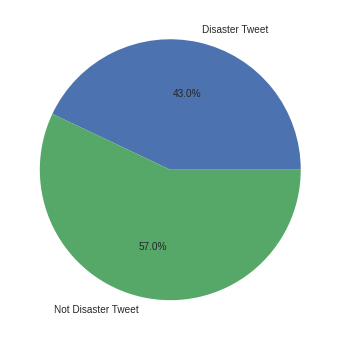

In [0]:
print ("Distribution of diaster tweets\n")

labels = 'Disaster Tweet', 'Not Disaster Tweet'
slices = [dist_tweets['target'].size,ndist_tweets['target'].size]

fig, ax = plt.subplots(figsize=(8,6))

ax.pie(slices,labels=labels,autopct='%1.1f%%')

In [0]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

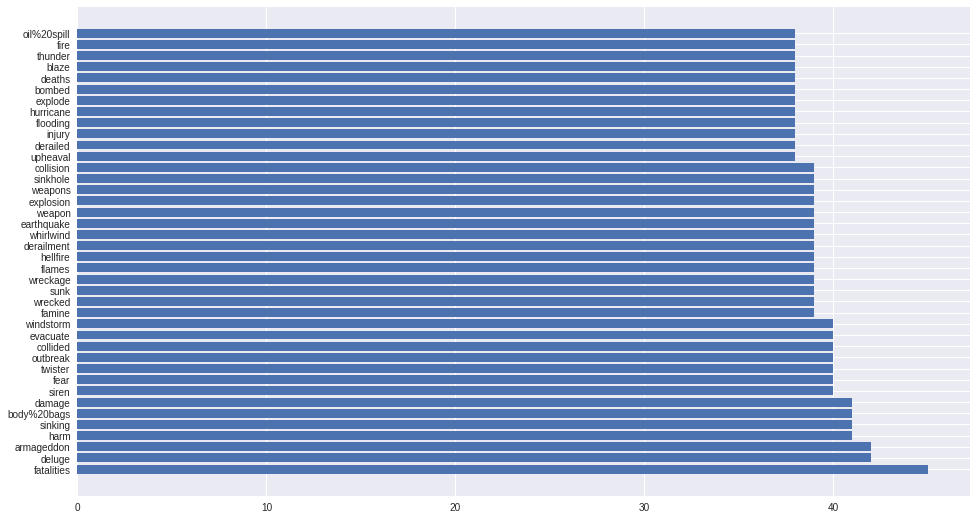

In [0]:
keywords=train['keyword'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(keywords.keys()[:40]) 
values = list(keywords[:40])
# Horizontal Bar Plot 
ax.barh(keys,values) 
# Show Plot 
plt.show() 

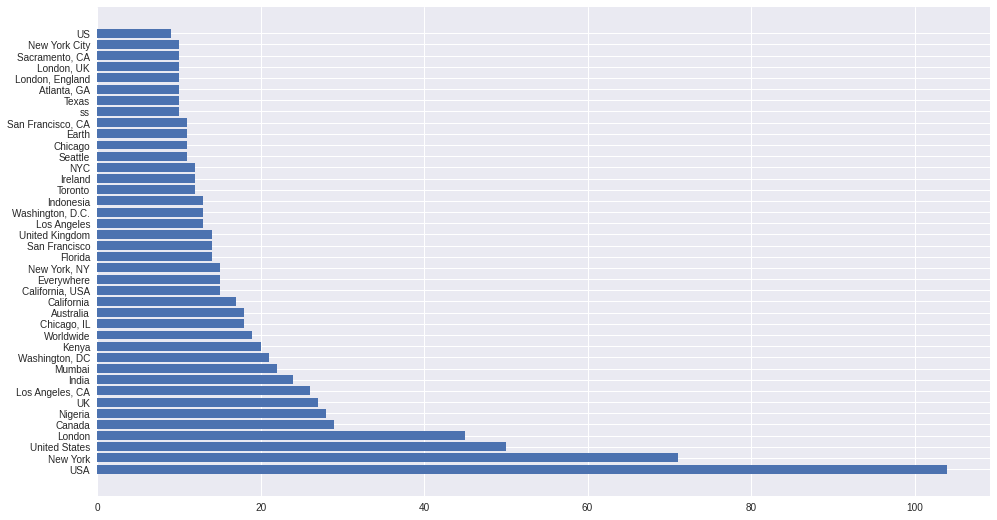

In [0]:
locations=train['location'].value_counts()
fig, ax = plt.subplots(figsize =(16, 9))

keys = list(locations.keys()[:40]) 
values = list(locations[:40])
# Horizontal Bar Plot 
ax.barh(keys,values) 
# Show Plot 
plt.show() 

In [0]:
# word_count
dist_word_count = dist_tweets['text'].apply(lambda x: len(str(x).split()))
ndist_word_count = ndist_tweets['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
dist_uword_count = dist_tweets['text'].apply(lambda x: len(set(str(x).split())))
ndist_uword_count= ndist_tweets['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
dist_sword_count = dist_tweets['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
ndist_sword_count = ndist_tweets['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

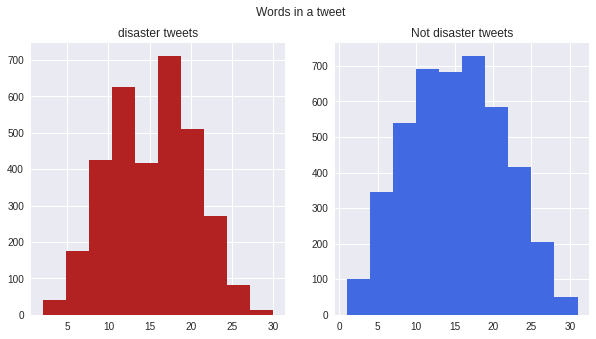

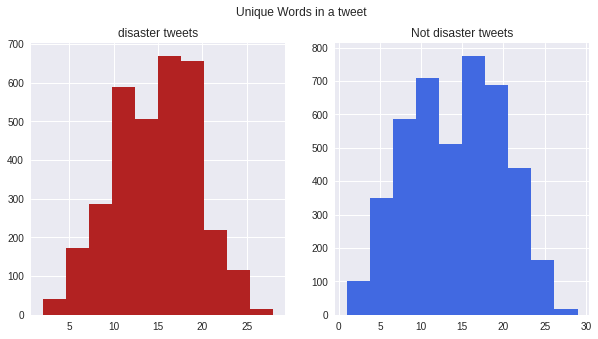

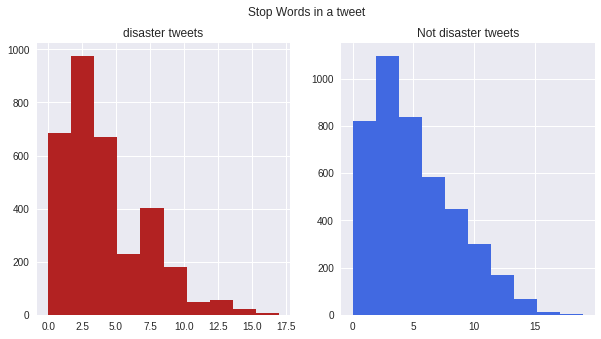

In [0]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_word_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_word_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_uword_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_uword_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Unique Words in a tweet')
plt.show()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(dist_sword_count,color='firebrick')
ax1.set_title('disaster tweets')

ax2.hist(ndist_sword_count,color='royalblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Stop Words in a tweet')
plt.show()

In [0]:
def fill_dict(dic, w):
    if w in dic:
      dic[w]+=1
    else:
      dic[w]=1

def count_words(dic, words, stopwords=0):
  for w in words:
    if stopwords:
      if w not in STOP:
        fill_dict(dic,w)
    else:
        fill_dict(dic,w)

In [0]:
count = {}
dist_tweets['text'].apply(lambda x: count_words(count,x.lower().split(),1))
count_without_stop = sorted(count.items(), key=lambda item: item[1], reverse=True)

count = {}
ndist_tweets['text'].apply(lambda x: count_words(count,x.lower().split(),1))
count_without_stop2 = sorted(count.items(), key=lambda item: item[1], reverse=True)

In [0]:
def plot_common_words(one,two ):
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,9))
  keys=[]
  values=[]  
  keys2=[]
  values2=[]
  for i in range(20):
    keys.append(one[i][0])
    values.append(one[i][1])
    keys2.append(two[i][0])
    values2.append(two[i][1])

  ax1.barh(keys,values,color='firebrick')
  ax1.set_title('Disaster Tweets')

  ax2.barh(keys2,values2,color='royalblue')
  ax2.set_title('Not Disaster Tweets')
  fig.suptitle('Common words')
  plt.show()

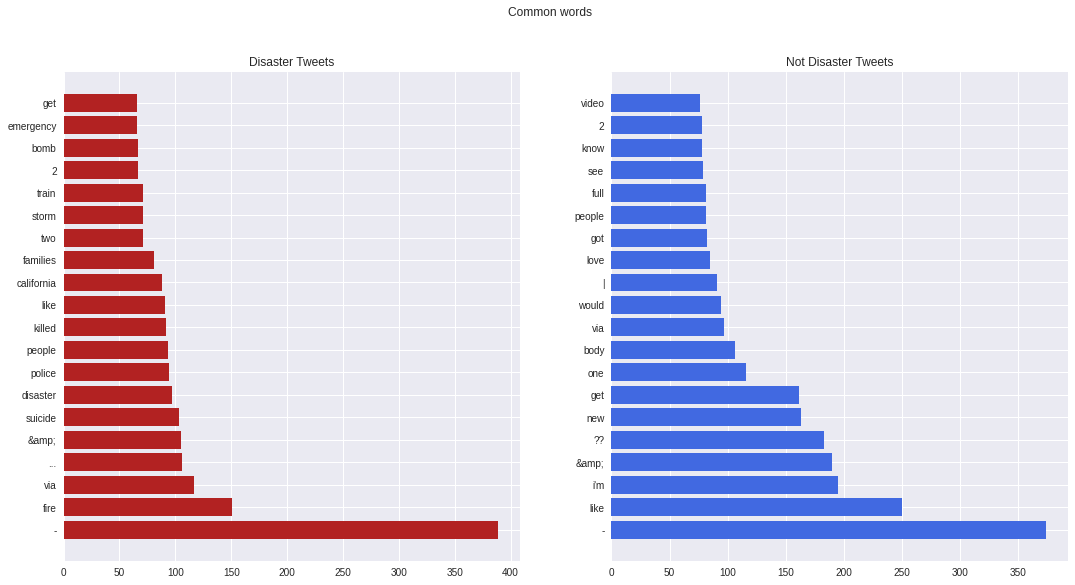

In [0]:
plot_common_words(count_without_stop,count_without_stop2)

#DATA CLEANING

In [0]:
train = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/test.csv', dtype={'id': np.int16})

In [0]:
#Data Cleaning
#all to lower case
#remove punctiaction and other characters etc
#remove Stop words

def clean_data(x):
  x= x.lower()
  x = re.sub('https?://\S+|www\.\S+', '', x)
  x = re.sub("'", " ", x)
  x = re.sub(r"&gt;", "", x)
  x = re.sub(r"&lt;", "", x)
  x = re.sub(r"&amp;", "", x)
  x = re.sub(r"\n", " ", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"åê", "", x)
  x = re.sub(r"\x89ûï", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89û", "", x)
  x = re.sub(r"\x9d", "", x)
  x = re.sub('\w*\d\w*', '', x)
  x = re.sub('ì©', 'é', x)
  x = re.sub("[@.!?\\-*#+_:,;=><'§$%&/°^`´{}>|~()]", "",x)
  return x

train['text']=train['text'].apply(lambda x: clean_data(x))
test['text']=test['text'].apply(lambda x: clean_data(x))

In [7]:
train['text'].values[:10]
test['text'].values[:10]

array(['just happened a terrible car crash',
       'heard about earthquake is different cities stay safe everyone',
       'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all',
       'apocalypse lighting spokane wildfires',
       'typhoon soudelor kills  in china and taiwan',
       'we re shakingit s an earthquake',
       'they d probably still show more life than arsenal did yesterday eh eh',
       'hey how are you', 'what a nice hat', 'fuck off'], dtype=object)

In [0]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

In [0]:
def remove_stopwords(tokens):
  toke=[]
  for t in tokens: 
    if t not in STOP:
       toke.append(t)
  return toke

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))

In [10]:
def combine_tokens(tokens):
  a=""
  for t in tokens:
    a = a + t + " "
  return a

  
train['text'] = train['text'].apply(lambda x: combine_tokens(x))
test['text'] = test['text'].apply(lambda x: combine_tokens(x))
train['text'].head()

0        deeds reason earthquake may allah forgive us 
1               forest fire near la ronge sask canada 
2    residents asked shelter place notified officer...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

#Learning Models

##Naive Bayes

In [0]:
vec = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_vec = vec.fit_transform(train['text'])
test_vec = vec.transform(test["text"])

In [12]:
clf= MultinomialNB()
scores = model_selection.cross_val_score(clf, train_vec, train["target"], cv=5, scoring="f1")
scores

array([0.57847976, 0.56338028, 0.60173913, 0.58464385, 0.72347267])

In [13]:
x, x_test, y, y_test = train_test_split(train_vec,train["target"], random_state = 0)

clf.fit(x,y)
predicted = clf.predict(x_test)
 
# classification table
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
    print('\n \n')
    print(classification_report(exp, pred))

printreport(y_test, predicted)

Predicted     0    1
Actual              
0          1022   85
1           299  498

 

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1107
           1       0.85      0.62      0.72       797

    accuracy                           0.80      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.81      0.80      0.79      1904



In [0]:
nbPredictions = clf.predict(test_vec)
submission = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/sample_submission.csv')
submission['target']= nbPredictions
submission.to_csv('submission.csv',index=False)

Naive Bayes bringt den Score von 0.78976 in Kaggle

##BERT Model

In [16]:
max_seq_length = 160  
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
clf_output = sequence_output[:, 0, :]

x = tf.keras.layers.Dropout(0.3)(clf_output)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#out = tf.keras.layers.Dense(1, activation='sigmoid')(clf_output)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [0]:
# from https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#7.-Model
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=max_seq_length)
test_input = bert_encode(test.text.values, tokenizer, max_len=max_seq_length)
train_labels = train.target.values

In [0]:
checkpoint =  tf.keras.callbacks.ModelCheckpoint('drive/model.h5', monitor='val_loss', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history=model.fit(
    train_input, train_labels,
    validation_split=0.3,
    callbacks=[checkpoint],
    epochs=3,
    batch_size=32
)

Train on 5329 samples, validate on 2284 samples
Epoch 1/3
2304/5329 [===========>..................] - ETA: 1:36:45 - loss: 0.5072 - accuracy: 0.7578

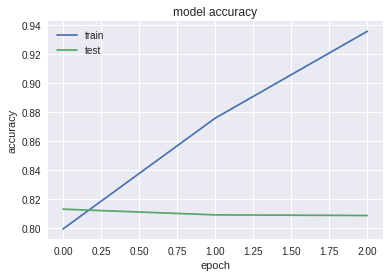

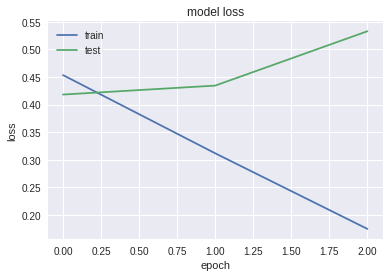

In [0]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
submission = pd.read_csv('/content/DataScienceSS20Project/nlp-getting-started/sample_submission.csv')

In [0]:
model.trainable=False

optimizer = tf.keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.load_weights('model.h5')
train_pred = model.predict(test_input)


In [0]:
submission['target'] = train_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

Erste Kaggel Score mit Bert bei 0.80968
learning_rate 0.00001

Zeigt Overfitting Verhalten weil der Val Loss steigt und die Accuracy gleich/sinkt -> mit Kombination von Dropout vielleicht besser
